In [1]:
# imports

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print("Python:", os.sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)

Python: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
TensorFlow: 2.20.0


In [3]:
# connecting to the internet to download the dataset

import requests
print(requests.get("https://www.google.com").status_code)

200


In [4]:
#load & preprocess

from tensorflow.keras.datasets import cifar10

# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels to 1D arrays
y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize images to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 84s 0us/step
Train shape: (50000, 32, 32, 3) (50000,)
Test shape: (10000, 32, 32, 3) (10000,)


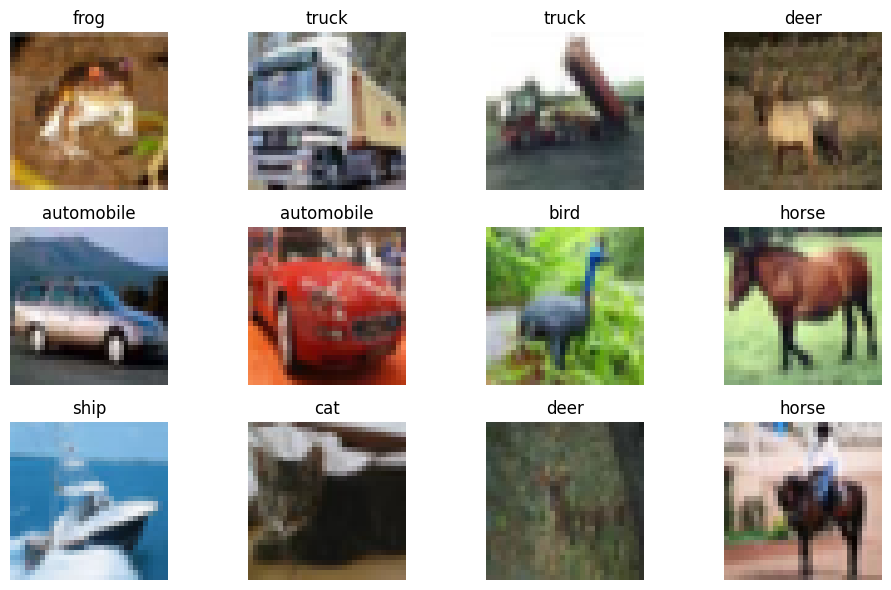

In [5]:
# sample images

plt.figure(figsize=(10,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

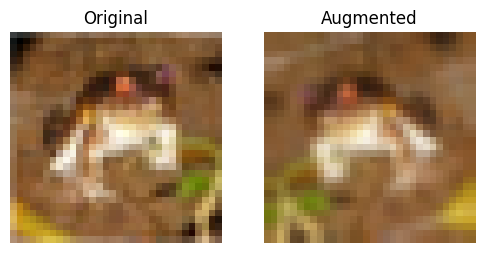

In [6]:
# data augmentation (Keras preprocessing layers)

from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name="data_augmentation")

# Example of augmented image display
plt.figure(figsize=(6,3))
augmented = data_augmentation(tf.expand_dims(x_train[0], 0), training=True)
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(x_train[0]); plt.axis('off')
plt.subplot(1,2,2); plt.title("Augmented"); plt.imshow(augmented[0].numpy()); plt.axis('off')


In [8]:
# build the CNN model

from tensorflow.keras import layers, models

def create_model(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,                      # apply augmentation in model pipeline
        layers.Rescaling(1./1),                 # already normalized; keep for pipeline
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 658,218 (2.51 MB)

 Trainable params: 658,218 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# compile & callbacks

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_cifar10.h5", save_best_only=True)
]


In [ ]:
# train the model

BATCH_SIZE = 64
EPOCHS = 50

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2843 - loss: 1.9259

782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.3650 - loss: 1.7291 - val_accuracy: 0.5122 - val_loss: 1.3483
Epoch 2/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4748 - loss: 1.4524

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.4895 - loss: 1.4117 - val_accuracy: 0.5353 - val_loss: 1.2897
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5296 - loss: 1.3103

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.5412 - loss: 1.2874 - val_accuracy: 0.6049 - val_loss: 1.0930
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5628 - loss: 1.2221

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.5694 - loss: 1.2107 - val_accuracy: 0.6453 - val_loss: 0.9958
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.5950 - loss: 1.1488 - val_accuracy: 0.6243 - val_loss: 1.0833
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6098 - loss: 1.1126

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6110 - loss: 1.1126 - val_accuracy: 0.6629 - val_loss: 0.9498
Epoch 7/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6199 - loss: 1.0758

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6248 - loss: 1.0668 - val_accuracy: 0.6737 - val_loss: 0.9258
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6252 - loss: 1.0576

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6288 - loss: 1.0490 - val_accuracy: 0.6894 - val_loss: 0.8912
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.6424 - loss: 1.0268 - val_accuracy: 0.6629 - val_loss: 0.9569
Epoch 10/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6488 - loss: 0.9989 - val_accuracy: 0.6864 - val_loss: 0.9188
Epoch 11/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6573 - loss: 0.9818

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6565 - loss: 0.9822 - val_accuracy: 0.6962 - val_loss: 0.8735
Epoch 12/50
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6677 - loss: 0.9548

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6655 - loss: 0.9583 - val_accuracy: 0.7209 - val_loss: 0.7912
Epoch 13/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.6712 - loss: 0.9467 - val_accuracy: 0.7038 - val_loss: 0.8548
Epoch 14/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.6722 - loss: 0.9358 - val_accuracy: 0.7139 - val_loss: 0.8171
Epoch 15/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6790 - loss: 0.9219 - val_accuracy: 0.7135 - val_loss: 0.8330
Epoch 16/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6830 - loss: 0.9101 - val_accuracy: 0.7181 - val_loss: 0.8154
Epoch 17/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6857 - loss: 0.9005

782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.6856 - loss: 0.9044 - val_accuracy: 0.7258 - val_loss: 0.7695
Epoch 18/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.6885 - loss: 0.8966 - val_accuracy: 0.7109 - val_loss: 0.8307
Epoch 19/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6940 - loss: 0.8714

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6893 - loss: 0.8831 - val_accuracy: 0.7340 - val_loss: 0.7613
Epoch 20/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6930 - loss: 0.8745 - val_accuracy: 0.7276 - val_loss: 0.7870
Epoch 21/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6969 - loss: 0.8724 - val_accuracy: 0.7359 - val_loss: 0.7698
Epoch 22/50
306/782 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.7059 - loss: 0.8421

In [ ]:
# plot training & validation accuracy/loss

hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

plt.tight_layout()


In [ ]:
# evaluate on test set and show accuracy

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

In [ ]:
# confusion matrix (no scikit-learn dependency)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf

# Predict classes
y_pred_proba = model.predict(x_test, batch_size=128)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix using TF
cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=10).numpy()

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# annotate counts
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()


In [ ]:
# save final model and sample predictions CSV (optional)

# Save model
model.save("cifar10_cnn.h5")
print("Saved model to cifar10_cnn.h5")

# Save predictions (optional)
import pandas as pd
df_preds = pd.DataFrame({
    "true": y_test,
    "pred": y_pred
})
df_preds.to_csv("predictions.csv", index=False)
print("Saved predictions.csv")
